## Data Setup

In [32]:
import csv
import pandas as pd
import seaborn as sns

In [33]:
file = '/content/amazon_training_data.csv'

In [34]:
pd.read_csv(file)

reviewerName  overall  \
0                              Nick Wilson        5   
1                                   Andy B        5   
2                                  Craig A        5   
3                           Karl Carpenter        5   
4                                       ML        4   
...                                    ...      ...   
3927  T.Chance "Travis Chance Photography"        5   
3928                                 Arnob        5   
3929                               M. Cruz        4   
3930                           R.D. "R.D."        5   
3931                         catchemall447        4   

                                             reviewText reviewTime  
0     This is an ultra fast SanDisk branded SD card ...   12/20/13  
1     I use this for a dash mounted camera for my co...    4/22/14  
2     I purchased this to put into my Samsung Galaxy...    6/20/13  
3     Noticeable improvement to my Sprint HTC EVO LT...     7/1/13  
4     It was exactly the memory card I ordered. I te...   12/17/12  
...                                                 ...        ...  
3927  Use with my GoPro Hero 3 & class 10 is a must....    3/29/13  
3928  Fast shipping & delivered as described.Phone d...    9/20/13  
3929  Bought two, one for me and one for my husband....   12/12/12  
3930  This 32GB card is fast.  Great for storing vid...     4/1/14  
3931  Previously purchased two ADATA microsd cards o...    12/9/12  

[3932 rows x 4 columns]

In [35]:
data_list = []

In [36]:
EXPECTED_COLUMNS = 4

In [37]:
with open(file, mode='r', newline='', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader)

    for row in reader:
        if len(row) == EXPECTED_COLUMNS:
            data_list.append(row)
        else:
            print(f"Skipping row {reader.line_num}: {row}")

data = pd.DataFrame(data_list, columns=header)

print(data.head())

     reviewerName overall                                         reviewText  \
0     Nick Wilson       5  This is an ultra fast SanDisk branded SD card ...   
1          Andy B       5  I use this for a dash mounted camera for my co...   
2         Craig A       5  I purchased this to put into my Samsung Galaxy...   
3  Karl Carpenter       5  Noticeable improvement to my Sprint HTC EVO LT...   
4              ML       4  It was exactly the memory card I ordered. I te...   

  reviewTime  
0   12/20/13  
1    4/22/14  
2    6/20/13  
3     7/1/13  
4   12/17/12  


## Data Exploration and Preprocessing

In [38]:
data_types = data.dtypes

if data['overall'].dtype == 'object':
    data['overall'] = pd.to_numeric(data['overall'], errors='coerce')

new_data_types = data.dtypes
missing_values = data.isnull().sum()

data_types, new_data_types, missing_values

(reviewerName    object
 overall         object
 reviewText      object
 reviewTime      object
 dtype: object,
 reviewerName    object
 overall          int64
 reviewText      object
 reviewTime      object
 dtype: object,
 reviewerName    0
 overall         0
 reviewText      0
 reviewTime      0
 dtype: int64)

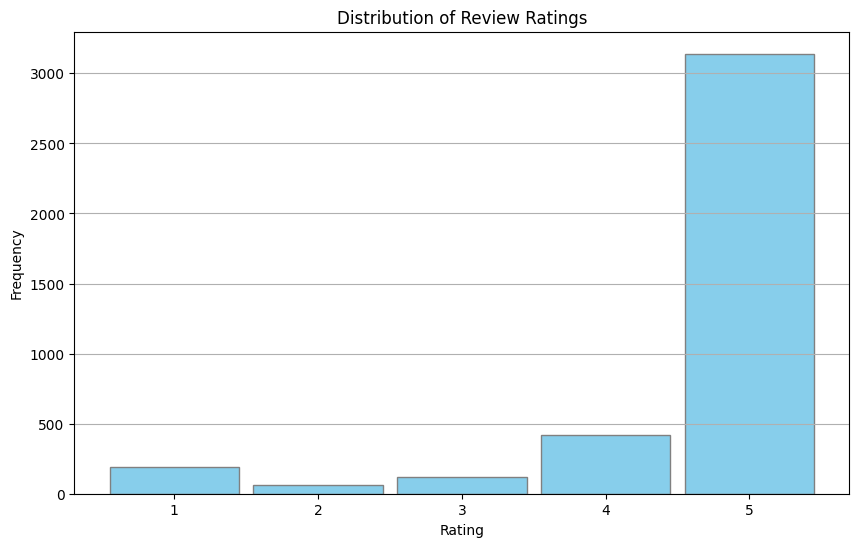

count    3932.000000
mean        4.590285
std         0.992589
min         1.000000
25%         5.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: overall, dtype: float64

In [39]:
import matplotlib.pyplot as plt

review_rating_stats = data['overall'].describe()

plt.figure(figsize=(10, 6))
plt.hist(data['overall'].dropna(), bins=range(1, 7), align='left', rwidth=0.9, color='skyblue', edgecolor='gray')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(range(1, 6))
plt.grid(axis='y')
plt.show()

review_rating_stats

In [40]:
clean_data = data.dropna()

new_shape = clean_data.shape

clean_data['comment_length'] = clean_data['reviewText'].apply(len)

correlation = clean_data[['overall', 'comment_length']].corr()

new_shape, correlation


((3932, 4),
                  overall  comment_length
 overall         1.000000       -0.253679
 comment_length -0.253679        1.000000)

In [41]:
import re

patterns = {
    "positive_emphasis": re.compile(r'\b(great|good|excellent|amazing|love|best|awesome|fantastic)\b', re.IGNORECASE),
    "negative_emphasis": re.compile(r'\b(bad|terrible|awful|poor|worst|hate|disappoint)\b', re.IGNORECASE),
    "question": re.compile(r'\?'),
    "exclamation": re.compile(r'!'),
    "capital_words": re.compile(r'\b[A-Z]{2,}\b')
}

pattern_counts = {key: 0 for key in patterns}

for review in clean_data['reviewText']:
    for key, pattern in patterns.items():
        if re.search(pattern, review):
            pattern_counts[key] += 1

pattern_counts


{'positive_emphasis': 1862,
 'negative_emphasis': 131,
 'question': 165,
 'exclamation': 634,
 'capital_words': 1501}

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
import string

def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

clean_data.loc[:, 'reviewText'] = clean_data.loc[:, 'reviewText'].apply(clean_text)

X = clean_data.loc[:, 'reviewText']
y = clean_data.loc[:, 'reviewText']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [43]:
vectorizer = TfidfVectorizer(stop_words='english')

model = MultinomialNB()

text_clf = make_pipeline(vectorizer, model)

text_clf.fit(X_train, y_train)

y_pred = text_clf.predict(X_test)

report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

report, conf_matrix

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

('                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [44]:
from sklearn.utils import resample

df_majority = clean_data[clean_data.overall == 5]
df_minority = clean_data[clean_data.overall < 5]

df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.overall.value_counts()


5    3140
4    1637
1     799
3     480
2     224
Name: overall, dtype: int64

In [45]:
X_upsampled = df_upsampled['reviewText']
y_upsampled = df_upsampled['overall']

X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(
    X_upsampled, y_upsampled, test_size=0.2, random_state=42)

text_clf_upsampled = make_pipeline(vectorizer, model)
text_clf_upsampled.fit(X_train_upsampled, y_train_upsampled)

y_pred_upsampled = text_clf_upsampled.predict(X_test_upsampled)

report_upsampled = classification_report(y_test_upsampled, y_pred_upsampled)

conf_matrix_upsampled = confusion_matrix(y_test_upsampled, y_pred_upsampled)

report_upsampled, conf_matrix_upsampled

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


('              precision    recall  f1-score   support\n\n           1       0.90      0.54      0.67       156\n           2       0.00      0.00      0.00        42\n           3       1.00      0.06      0.11        99\n           4       0.94      0.37      0.53       314\n           5       0.62      1.00      0.76       645\n\n    accuracy                           0.67      1256\n   macro avg       0.69      0.39      0.42      1256\nweighted avg       0.75      0.67      0.62      1256\n',
 array([[ 84,   0,   0,   3,  69],
        [  1,   0,   0,   0,  41],
        [  7,   0,   6,   1,  85],
        [  1,   0,   0, 115, 198],
        [  0,   0,   0,   3, 642]]))

## Classifying Ratings

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


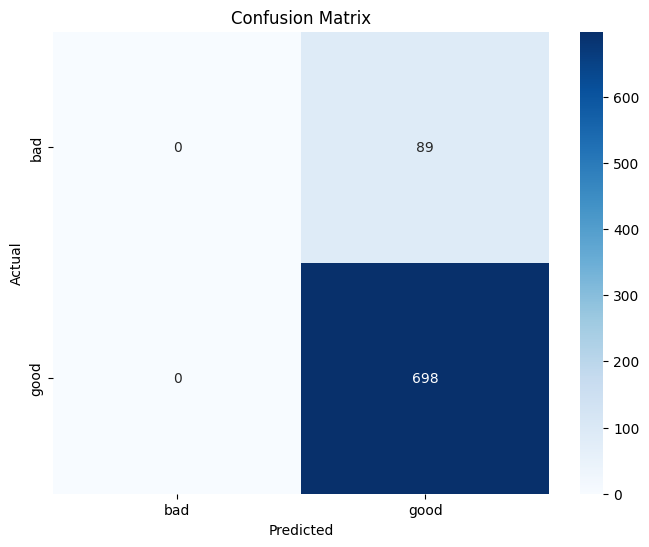

precision    recall  f1-score     support
bad            0.000000  0.000000  0.000000   89.000000
good           0.886912  1.000000  0.940067  698.000000
accuracy       0.886912  0.886912  0.886912    0.886912
macro avg      0.443456  0.500000  0.470034  787.000000
weighted avg   0.786613  0.886912  0.833757  787.000000

In [46]:
def binary_rating(rating):
    if rating >= 4:
        return 'good'
    else:
        return 'bad'

binary_data = clean_data.copy()
binary_data['overall'] = binary_data['overall'].apply(binary_rating)

X_binary = binary_data['reviewText']
y_binary = binary_data['overall']

X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42)

text_clf_binary = make_pipeline(vectorizer, model)
text_clf_binary.fit(X_train_binary, y_train_binary)

y_pred_binary = text_clf_binary.predict(X_test_binary)

report_binary = classification_report(y_test_binary, y_pred_binary, output_dict=True)

conf_matrix_binary = confusion_matrix(y_test_binary, y_pred_binary)

report_binary_df = pd.DataFrame(report_binary).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_binary_df


In [47]:
df_majority_binary = binary_data[binary_data.overall == 'good']
df_minority_binary = binary_data[binary_data.overall == 'bad']

df_minority_upsampled_binary = resample(df_minority_binary,
                                        replace=True,
                                        n_samples=len(df_majority_binary),
                                        random_state=42)

df_upsampled_binary = pd.concat([df_majority_binary, df_minority_upsampled_binary])

df_upsampled_binary.overall.value_counts()


good    3561
bad     3561
Name: overall, dtype: int64

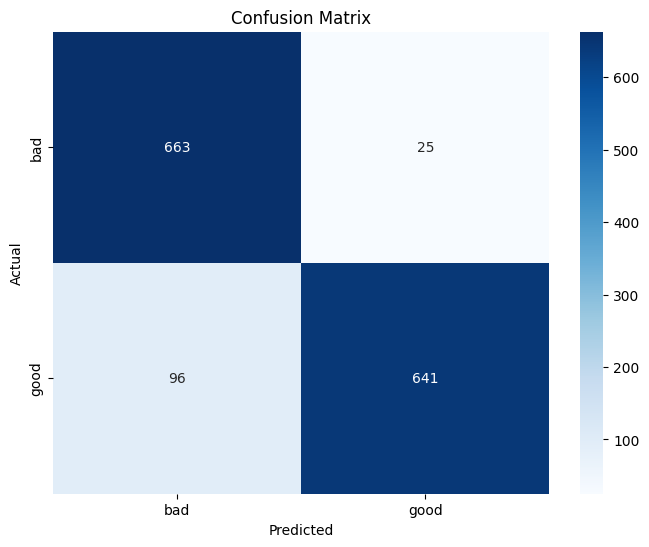

precision    recall  f1-score      support
bad            0.873518  0.963663  0.916379   688.000000
good           0.962462  0.869742  0.913756   737.000000
accuracy       0.915088  0.915088  0.915088     0.915088
macro avg      0.917990  0.916702  0.915067  1425.000000
weighted avg   0.919519  0.915088  0.915022  1425.000000

In [48]:
X_upsampled_binary = df_upsampled_binary['reviewText']
y_upsampled_binary = df_upsampled_binary['overall']

X_train_upsampled_binary, X_test_upsampled_binary, y_train_upsampled_binary, y_test_upsampled_binary = train_test_split(
    X_upsampled_binary, y_upsampled_binary, test_size=0.2, random_state=42)

text_clf_upsampled_binary = make_pipeline(vectorizer, model)
text_clf_upsampled_binary.fit(X_train_upsampled_binary, y_train_upsampled_binary)

y_pred_upsampled_binary = text_clf_upsampled_binary.predict(X_test_upsampled_binary)

report_upsampled_binary = classification_report(y_test_upsampled_binary, y_pred_upsampled_binary, output_dict=True)

conf_matrix_upsampled_binary = confusion_matrix(y_test_upsampled_binary, y_pred_upsampled_binary)

report_upsampled_binary_df = pd.DataFrame(report_upsampled_binary).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_upsampled_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_upsampled_binary_df

## Testing Set

<ipython-input-49-7c7f38a0f91c>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_set = pd.read_csv('/content/amazon_test_data.csv', error_bad_lines=False, warn_bad_lines=True)
<ipython-input-49-7c7f38a0f91c>:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  test_set = pd.read_csv('/content/amazon_test_data.csv', error_bad_lines=False, warn_bad_lines=True)


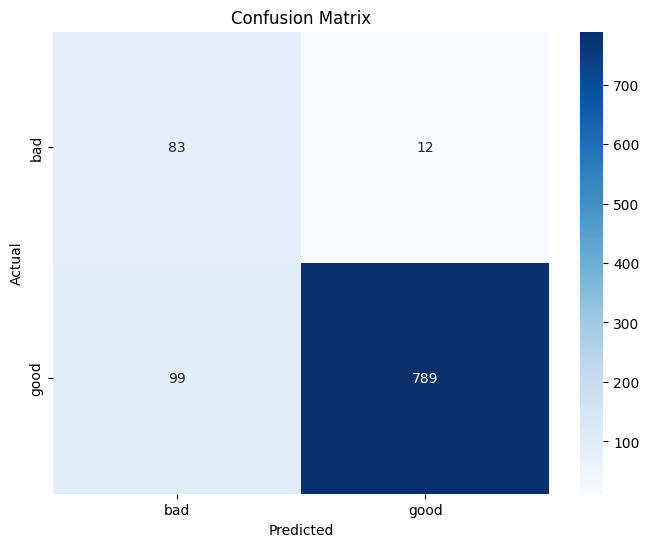

(              precision    recall  f1-score    support
 bad            0.456044  0.873684  0.599278   95.00000
 good           0.985019  0.888514  0.934281  888.00000
 accuracy       0.887080  0.887080  0.887080    0.88708
 macro avg      0.720531  0.881099  0.766779  983.00000
 weighted avg   0.933897  0.887080  0.901905  983.00000,
           reviewerName overall  \
 0             J. Morse    good   
 1             Steven K     bad   
 2       Brandon Batson     bad   
 3        Robert Sommer    good   
 4  Joseph Criniti, Jr.    good   
 
                                           reviewText reviewTime  
 0  when i opened the micro disc and adapter i did...     9/9/13  
 1  i purchased this product knowing there might b...    5/24/14  
 2  bought october 7th passed away december 23rd r...   12/24/12  
 3  this was an inexpensive way to get my galaxy n...     5/3/14  
 4  works well and fast does everything it claims ...   10/17/12  )

In [49]:
test_set = pd.read_csv('/content/amazon_test_data.csv', error_bad_lines=False, warn_bad_lines=True)

test_set_clean = test_set.dropna(subset=['reviewText', 'overall'])

test_set_clean['overall'] = pd.to_numeric(test_set_clean['overall'], errors='coerce')

test_set_clean = test_set_clean.dropna(subset=['overall'])

def binary_rating(rating):
    return 'good' if rating >= 4.0 else 'bad'

test_set_clean['reviewText'] = test_set_clean['reviewText'].apply(clean_text)

test_set_clean['overall'] = test_set_clean['overall'].apply(binary_rating)

preprocessed_test_set_clean_structure = test_set_clean.head()

X_test_set_clean = test_set_clean['reviewText']
y_test_set_clean = test_set_clean['overall']

y_pred_test_set_clean = text_clf_upsampled_binary.predict(X_test_set_clean)

report_test_set_clean = classification_report(y_test_set_clean, y_pred_test_set_clean, output_dict=True)

conf_matrix_test_set_clean = confusion_matrix(y_test_set_clean, y_pred_test_set_clean)

report_test_set_clean_df = pd.DataFrame(report_test_set_clean).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_set_clean, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bad', 'good'], yticklabels=['bad', 'good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

report_test_set_clean_df, preprocessed_test_set_clean_structure